## Building an image classifier in TF2.0 (Practical introduction)

### Importing and preprocessing data

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [41]:
# List the available datasets
tfds.list_builders()

['bair_robot_pushing_small',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cifar10',
 'cifar100',
 'coco2014',
 'diabetic_retinopathy_detection',
 'dummy_dataset_shared_generator',
 'dummy_mnist',
 'fashion_mnist',
 'image_label_folder',
 'imagenet2012',
 'imdb_reviews',
 'lm1b',
 'lsun',
 'mnist',
 'moving_mnist',
 'nsynth',
 'omniglot',
 'open_images_v4',
 'quickdraw_bitmap',
 'squad',
 'starcraft_video',
 'svhn_cropped',
 'tf_flowers',
 'wmt_translate_ende',
 'wmt_translate_enfr']

In [42]:
# Since "cats_vs_dog" doesn't define standard splits, 
# use the subsplit feature to divide it into (train, validation, test)
# with 80%, 10%, 10% of the data respectively.
SPLIT_WEIGHTS = (8, 1, 1)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)
(raw_train, raw_validation, raw_test), metadata = tfds.load(name="tf_flowers", 
                                                            with_info=True,
                                                            split=list(splits),
# as_supervised: `bool`, if `True`, the returned `tf.data.Dataset`
# will have a 2-tuple structure `(input, label)`                                                            
                                                            as_supervised=True)

In [43]:
print(raw_train)
print(raw_validation)
print(raw_test)

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [44]:
IMG_SIZE = 128
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [45]:
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    # Resize the image if required
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    # Optionally apply data augmentation
    if np.random.rand() > 0.5:
        image = tf.image.flip_left_right(image)
    return image, label

train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [46]:
print(train)
print(validation)
print(test)

<MapDataset shapes: ((128, 128, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((128, 128, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((128, 128, 3), ()), types: (tf.float32, tf.int64)>


In [47]:
SHUFFLE_BUFFER_SIZE = 1024
BATCH_SIZE = 32

train = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation = validation.batch(BATCH_SIZE)
test = test.batch(BATCH_SIZE)
# (Optional) prefetch will enable the input pipeline to asynchronously fetch batches while
# your model is training.
train = train.prefetch(tf.data.experimental.AUTOTUNE)
print(train)
print(validation)
print(test)

<PrefetchDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int64)>
<BatchDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int64)>
<BatchDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int64)>


In [48]:
print(metadata)

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=1.0.0,
    description='A large set of images of flowers',
    urls=['http://download.tensorflow.org/example_images/flower_photos.tgz'],
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5)
    },
    total_num_examples=3670,
    splits={
        'train': <tfds.core.SplitInfo num_examples=3670>
    },
    supervised_keys=('image', 'label'),
    citation='"""
        @ONLINE {tfflowers,
        author = "The TensorFlow Team",
        title = "Flowers",
        month = "jan",
        year = "2019",
        url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }
        
    """',
)



<b> 
1. TFDS Reference: https://www.tensorflow.org/datasets/overview
2. For importing data from custom URL or disk location refer, Loading images using tf.data: https://www.tensorflow.org/alpha/tutorials/load_data/images

### Visualizing data

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
# Get the function which convert label indices to string
get_label_name = metadata.features['label'].int2str

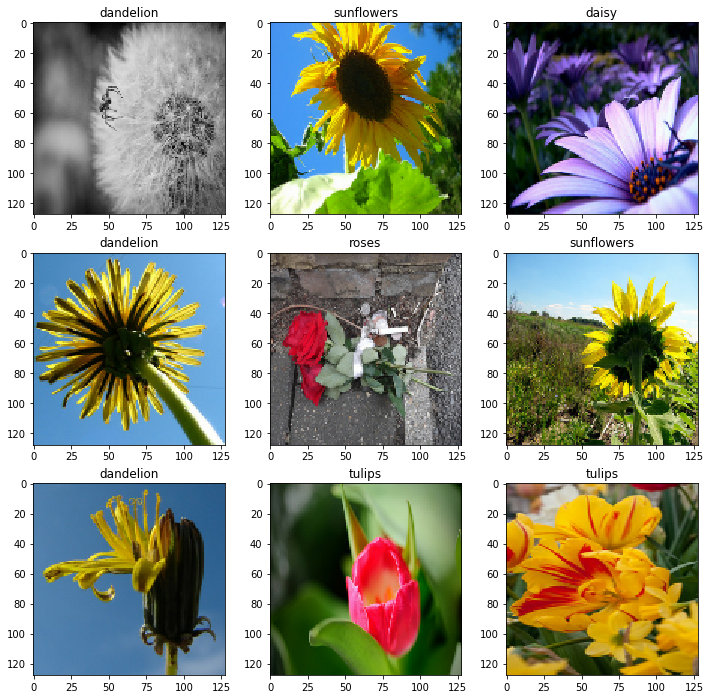

In [11]:
plt.figure(figsize=(12,12)) 
for batch in train.take(1):
    for i in range(9):
        image, label = batch[0][i], batch[1][i]
        plt.subplot(3,3,i+1)
        plt.imshow(image.numpy())
        plt.title(get_label_name(label.numpy()))
        plt.grid(False)

### Building image classifier model

In [12]:
from tensorflow import keras

def create_model():
    img_inputs = keras.Input(shape=IMG_SHAPE)
    conv_1 = keras.layers.Conv2D(32, (3, 3), activation='relu')(img_inputs)
    maxpool_1 = keras.layers.MaxPooling2D((2, 2))(conv_1)
    conv_2 = keras.layers.Conv2D(64, (3, 3), activation='relu')(maxpool_1)
    maxpool_2 = keras.layers.MaxPooling2D((2, 2))(conv_2)
    conv_3 = keras.layers.Conv2D(64, (3, 3), activation='relu')(maxpool_2)
    flatten = keras.layers.Flatten()(conv_3)
    dense_1 = keras.layers.Dense(64, activation='relu')(flatten)
    output = keras.layers.Dense(10, activation='softmax')(dense_1)

    model = keras.Model(inputs=img_inputs, outputs=output)
    
    return model

In [13]:
model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0     

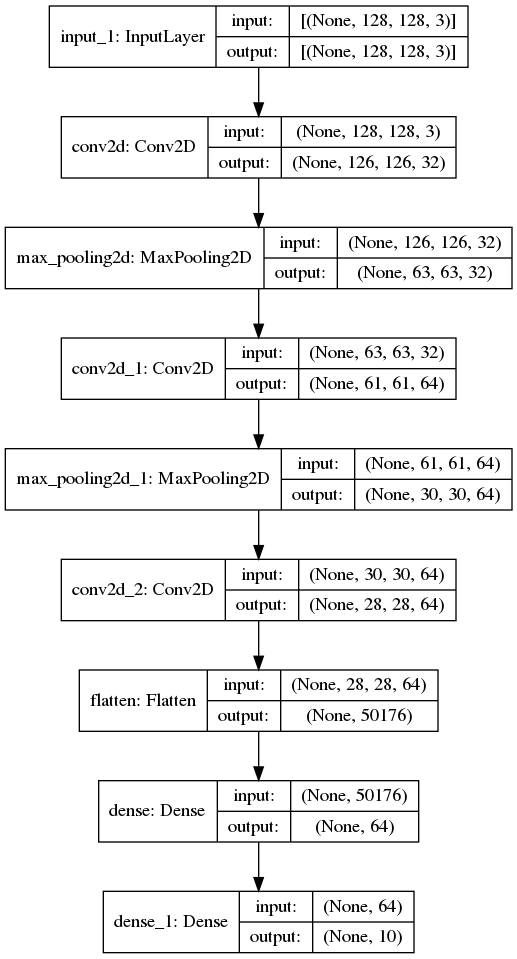

In [14]:
keras.utils.plot_model(model, 'fashion_model_with_shape_info.png', show_shapes=True)

### Training and model evaluation

In [15]:
import datetime, os

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(log_dir)

In [16]:
def train_model():
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(period=5)
    early_stopping_checkpoint = keras.callbacks.EarlyStopping(patience=5)

    steps_per_epoch = metadata.splits['train'].num_examples // BATCH_SIZE

    history = model.fit(train.repeat(),
              epochs=5, 
              steps_per_epoch=steps_per_epoch,
              validation_data=validation.repeat(),
              validation_steps=10,
              callbacks=[tensorboard_callback])
    
    return history

In [17]:
%load_ext tensorboard.notebook
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 9225), started 1:38:10 ago. (Use '!kill 9225' to kill it.)

In [78]:
!kill 9225

In [18]:
history = train_model()

Epoch 1/5
114/114 [==============================] - 104s 916ms/step - loss: 1.3634 - accuracy: 0.4334 - val_loss: 1.1723 - val_accuracy: 0.5033
Epoch 2/5
114/114 [==============================] - 103s 900ms/step - loss: 1.0243 - accuracy: 0.5962 - val_loss: 1.1137 - val_accuracy: 0.5828
Epoch 3/5
114/114 [==============================] - 100s 875ms/step - loss: 0.8258 - accuracy: 0.6859 - val_loss: 0.9626 - val_accuracy: 0.6126
Epoch 4/5
114/114 [==============================] - 100s 876ms/step - loss: 0.6320 - accuracy: 0.7648 - val_loss: 1.0810 - val_accuracy: 0.6457
Epoch 5/5
114/114 [==============================] - 94s 824ms/step - loss: 0.4127 - accuracy: 0.8577 - val_loss: 1.2868 - val_accuracy: 0.6523


### Using pre-trained model

In [6]:
from tensorflow import keras

# Create the base model from the pre-trained model MobileNet V2
base_model = keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')

9412608/9406464 [==============================] - 215s 23us/step


In [31]:
base_model.trainable = False
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalizationV1) (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

### Adding classification head

In [49]:
def build_model():
    
    model = keras.Sequential([
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(metadata.features['label'].num_classes, 
                           activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_7 ( (None, 1280)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


### Train the model

In [51]:
num_train, num_val, num_test = (
    metadata.splits['train'].num_examples*weight/10
    for weight in SPLIT_WEIGHTS
)

initial_epochs = 5
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = 10

loss0, accuracy0 = model.evaluate(validation.repeat(), steps = validation_steps)

10/10 [==============================] - 7s 731ms/step - loss: 2.2996 - accuracy: 0.1954


In [ ]:
history = model.fit(train.repeat(),
                    epochs=initial_epochs,
                    steps_per_epoch = steps_per_epoch,
                    validation_data=validation.repeat(), 
                    validation_steps=validation_steps)

In [19]:
# Save keras model
model.save('mobilenetv2_1.00_128_tf_flowes.h5')

In [22]:
loaded_model = keras.models.load_model('mobilenetv2_1.00_128_tf_flowes.h5')
model.evaluate(test)

      7/Unknown - 2s 276ms/step - loss: 1.0751 - accuracy: 0.7100

[1.0751061269215174, 0.71]

### Serving model in production

In [3]:
from tensorflow import keras

In [5]:
path_to_saved_model = 'SavedModel/mobilenetv2_1.00_128_tf_flowes/1'

In [24]:
# Saving the keras model in SavedModel format
keras.experimental.export_saved_model(model, path_to_saved_model)

In [6]:
restored_saved_model = keras.experimental.load_from_saved_model(path_to_saved_model)
# restored_saved_model.predict(test)

In [ ]:
!tensorflow_model_server --model_base_path=/home/ubuntu/Desktop/Medium/TF2.0/SavedModel/mobilenetv2_1.00_128_tf_flowes/ --rest_api_port=9000 --model_name=FlowerClassifier

In [18]:
import json
import requests
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.preprocessing import image
import numpy as np

In [19]:
image_path = 'sunflower.jpg'

In [73]:
def get_top_k_predictions(pred, k=3):
    predictions = np.array(pred['predictions'])[0]
    print('Top {} predictions:'.format(k))
    top_k_indices = np.argpartition(predictions, -k)[-k:]
    top_k_labels = list(map(get_label_name, top_k_indices))
    top_k_scores = predictions[top_k_indices]
    top_k_preds = list(zip(top_k_labels, top_k_scores))
    top_k_preds.sort(key=lambda x: -x[1])
    print(top_k_preds)

In [77]:
# Preprocessing our input image
img = image.img_to_array(image.load_img(image_path, target_size=(128, 128))) / 255.
img = np.expand_dims(img, axis=0)
payload = {"instances": img.tolist()}

# headers = {"content-type": "application/json"}
# sending post request to TensorFlow Serving server
json_response = requests.post('http://localhost:9000/v1/models/FlowerClassifier:predict', json=payload)
pred = json.loads(json_response.content.decode('utf-8'))

# Decoding the response
# decode_predictions(preds, top=5) by default gives top 5 results
# You can pass "k=5" to get top 5 predicitons
get_top_k_predictions(pred, k=3)

Top 3 predictions:
[('sunflowers', 0.978735), ('tulips', 0.0145516), ('roses', 0.00366251)]
